In [1]:
import sqlite3
import pandas as pd

In [2]:
# connect to the database
conn = sqlite3.connect('..\max-experiments\itinerary-scraping\journeys.db')

In [3]:
# display the schema
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('journeys',), ('stops',), ('outages',)]


### Display the contents of 'journeys' table

In [4]:
cursor.execute("SELECT * FROM journeys")
# cursor.fetchall()

In [5]:
# get the total duration of all journeys
cursor.execute("SELECT total_duration FROM journeys")

durations = cursor.fetchall()
durations = [duration[0] for duration in durations]


In [6]:
median_duration = sorted(durations)[len(durations) // 2]
print("Median duration: ", median_duration)

average_duration = sum(durations) / len(durations)
print("Average duration: ", round(average_duration, 3))

std_dev = (sum([(duration - average_duration) ** 2 for duration in durations]) / len(durations)) ** 0.5
print("Standard deviation: ", round(std_dev, 3))

Median duration:  3449
Average duration:  3679.093
Standard deviation:  1925.065


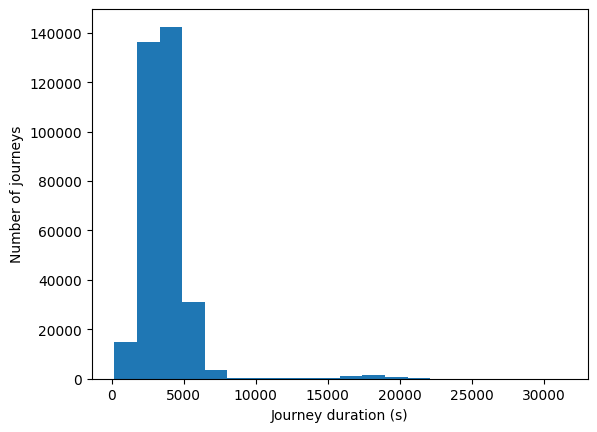

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# box plot of the durations
plt.boxplot(durations, widths=0.5)
plt.ylabel('Journey duration (s)')
plt.xticks([1], ['Journeys'])
plt.savefig('out/journeys/boxplot.png')
plt.close()

# plot the durations in a histogram
# x-axis: journey duration in seconds
# y-axis: number of journeys in bin
plt.hist(durations, bins=20)
plt.xlabel('Journey duration (s)')
plt.ylabel('Number of journeys')
plt.savefig('out/journeys/histogram.png')
plt.show()

In [8]:
q1 = np.percentile(durations, 25)
q3 = np.percentile(durations, 75)
iqr = q3 - q1
durations_no_outliers = [duration for duration in durations if duration < q3 + 1.5 * iqr]

median_duration_no_outliers = sorted(durations_no_outliers)[len(durations_no_outliers) // 2]
print("Median duration (no outliers): ", median_duration_no_outliers)

average_duration_no_outliers = sum(durations_no_outliers) / len(durations_no_outliers)
print("Average duration (no outliers): ", round(average_duration_no_outliers, 3))

std_dev_no_outliers = (sum([(duration - average_duration_no_outliers) ** 2 for duration in durations_no_outliers]) / len(durations_no_outliers)) ** 0.5
print("Standard deviation (no outliers): ", round(std_dev_no_outliers, 3))

Median duration (no outliers):  3414
Average duration (no outliers):  3458.489
Standard deviation (no outliers):  1051.862


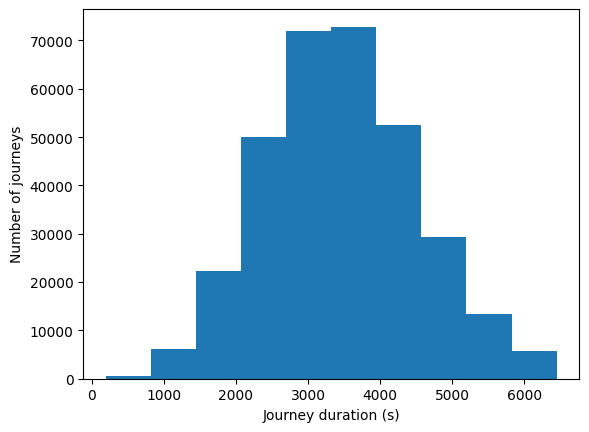

In [9]:
# box plot of the durations without outliers
plt.boxplot(durations_no_outliers, widths=0.5)
plt.ylabel('Journey duration (s)')
# save as a PNG file and reset the plot
plt.savefig('out/journeys/no_outliers_boxplot.png')
plt.close()

# plot the durations without outliers in a histogram
# x-axis: journey duration in seconds
# y-axis: number of journeys in bin
plt.hist(durations_no_outliers)
plt.xlabel('Journey duration (s)')
plt.ylabel('Number of journeys')
plt.savefig('out/journeys/no_outliers_histogram.png')
plt.show()

In [10]:
# number of outliers
num_outliers = len(durations) - len(durations_no_outliers)
print('Number of outliers:', num_outliers)
print('Percentage of outliers:', round(num_outliers / len(durations) * 100, 3), '%')

Number of outliers: 8306
Percentage of outliers: 2.493 %


### Plot departure datetime vs duration
(Doesn't seem extremely useful to me unless for some reason there was a visible change in travel duration since we started scraping)

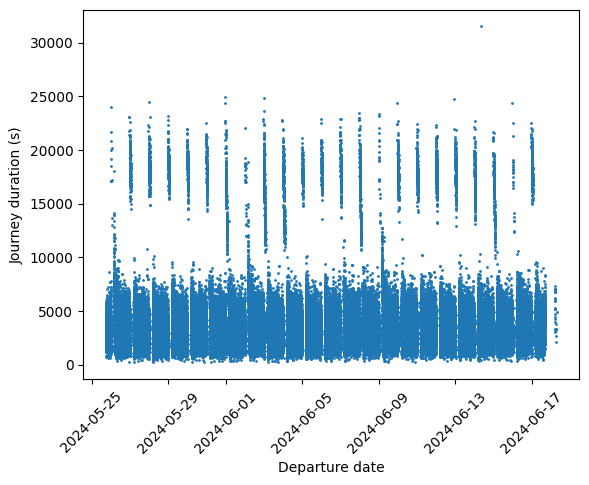

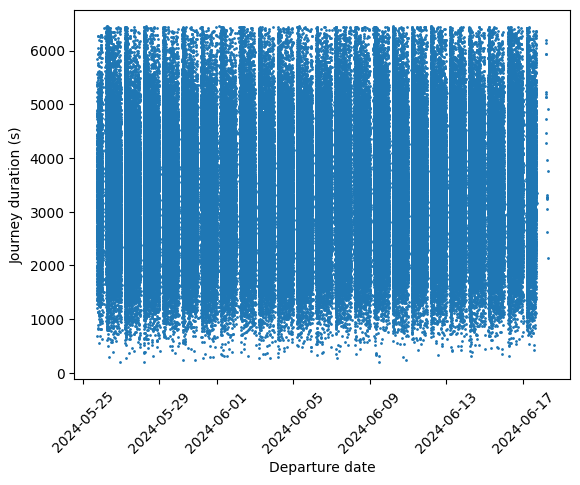

In [11]:
cursor.execute("SELECT * FROM journeys")
journeys = cursor.fetchall()

# departure datetime is in column 3 (index 2)
# get the departure datetime and duration of each journey
departures = [journey[2] for journey in journeys]
durations = [journey[1] for journey in journeys]

# convert the departure datetime to a numerical value
# format: 20240525T175138
# required format: 2024-05-25T17:51:38
import datetime

departures = [datetime.datetime.strptime(departure, '%Y%m%dT%H%M%S') for departure in departures]
# remove outliers
departures_no_outliers = [departure for departure, duration in zip(departures, durations) if duration < q3 + 1.5 * iqr]

# plot the departure datetime vs duration
plt.scatter(departures, durations, s=1)
plt.xlabel('Departure date')
plt.ylabel('Journey duration (s)')
plt.xticks(rotation=45)
plt.savefig('out/journeys/scatter.png')
plt.show()

# same without outliers
plt.scatter(departures_no_outliers, [duration for duration in durations if duration < q3 + 1.5 * iqr], s=1)
plt.xlabel('Departure date')
plt.ylabel('Journey duration (s)')
plt.xticks(rotation=45)
plt.savefig('out/journeys/no_outliers_scatter.png')
plt.show()

In [12]:
# 
cursor.execute("SELECT * FROM journeys WHERE total_duration < ?", (q3 + 1.5 * iqr,))
journeys = cursor.fetchall()
journeys_df = pd.DataFrame(journeys, columns=['id', 'total_duration', 'departure_datetime', 'arrival_datetime', 'gEC', 'nox_pm', 'method_breakdown_per_time_spent', 'method', 'path_timestamped'])

journeys_df

,id,total_duration,departure_datetime,arrival_datetime,gEC,nox_pm,method_breakdown_per_time_spent,method,path_timestamped
0,1,2972,20240525T175138,20240525T184110,"{""value"": 933.1212, ""unit"": ""gEC""}","{""unit"": ""g"", ""values"": {""nox"": 0, ""pm"": 0}}","{""total"": 2972, ""walking"": 1232, ""bike"": 0, ""c...","{""walking"": 272, ""bike"": 0, ""car"": 0, ""ridesha...","[{""stop_point"": ""Libert\u00e9"", ""arrival_date_..."
1,2,2636,20240525T173733,20240525T182129,"{""value"": 380.232, ""unit"": ""gEC""}","{""unit"": ""g"", ""values"": {""nox"": 0, ""pm"": 0}}","{""total"": 2636, ""walking"": 1436, ""bike"": 0, ""c...","{""walking"": 612, ""bike"": 0, ""car"": 0, ""ridesha...","[{""stop_point"": ""Pont de La Mulati\u00e8re"", ""..."
2,3,3025,20240525T174745,20240525T183810,"{""value"": 558.0722, ""unit"": ""gEC""}","{""unit"": ""g"", ""values"": {""nox"": 0, ""pm"": 0}}","{""total"": 3025, ""walking"": 1945, ""bike"": 0, ""c...","{""walking"": 586, ""bike"": 0, ""car"": 0, ""ridesha...","[{""stop_point"": ""Petit Versailles"", ""arrival_d..."
3,4,3685,20240525T174745,20240525T184910,"{""value"": 726.4134, ""unit"": ""gEC""}","{""unit"": ""g"", ""values"": {""nox"": 0, ""pm"": 0}}","{""total"": 3685, ""walking"": 1585, ""bike"": 0, ""c...","{""walking"": 586, ""bike"": 0, ""car"": 0, ""ridesha...","[{""stop_point"": ""Petit Versailles"", ""arrival_d..."
4,5,3685,20240525T174745,20240525T184910,"{""value"": 705.801, ""unit"": ""gEC""}","{""unit"": ""g"", ""values"": {""nox"": 0, ""pm"": 0}}","{""total"": 3685, ""walking"": 1525, ""bike"": 0, ""c...","{""walking"": 586, ""bike"": 0, ""car"": 0, ""ridesha...","[{""stop_point"": ""Petit Versailles"", ""arrival_d..."
...,...,...,...,...,...,...,...,...,...
324846,333153,3272,20240617T160709,20240617T170141,"{""value"": 306.0824, ""unit"": ""gEC""}","{""unit"": ""g"", ""values"": {""nox"": 0, ""pm"": 0}}","{""total"": 3272, ""walking"": 1323, ""bike"": 0, ""c...","{""walking"": 447, ""bike"": 0, ""car"": 0, ""ridesha...","[{""stop_point"": ""Cr\u00e9cy"", ""arrival_date_ti..."
324847,333154,3640,20240617T160709,20240617T170749,"{""value"": 825.3344, ""unit"": ""gEC""}","{""unit"": ""g"", ""values"": {""nox"": 0, ""pm"": 0}}","{""total"": 3640, ""walking"": 1208, ""bike"": 0, ""c...","{""walking"": 341, ""bike"": 0, ""car"": 0, ""ridesha...","[{""stop_point"": ""Cr\u00e9cy"", ""arrival_date_ti..."
324848,333155,4406,20240617T160709,20240617T172035,"{""value"": 1378.1406, ""unit"": ""gEC""}","{""unit"": ""g"", ""values"": {""nox"": 0, ""pm"": 0}}","{""total"": 4406, ""walking"": 1166, ""bike"": 0, ""c...","{""walking"": 304, ""bike"": 0, ""car"": 0, ""ridesha...","[{""stop_point"": ""Cr\u00e9cy"", ""arrival_date_ti..."
324849,333156,3256,20240617T161530,20240617T170946,"{""value"": 1091.415, ""unit"": ""gEC""}","{""unit"": ""g"", ""values"": {""nox"": 0, ""pm"": 0}}","{""total"": 3256, ""walking"": 796, ""bike"": 0, ""ca...","{""walking"": 217, ""bike"": 0, ""car"": 0, ""ridesha...","[{""stop_point"": ""La Sarra"", ""arrival_date_time..."


### Average duration per day of the week


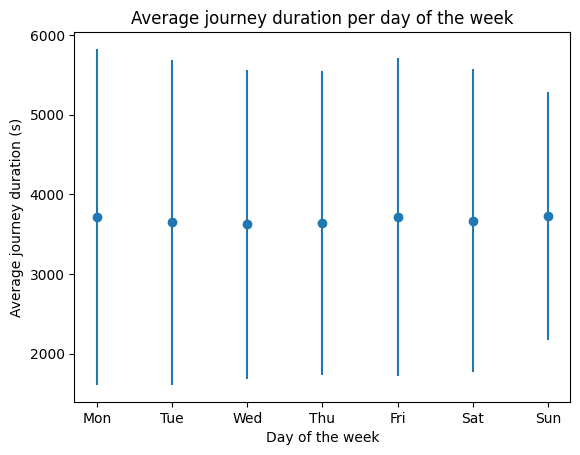

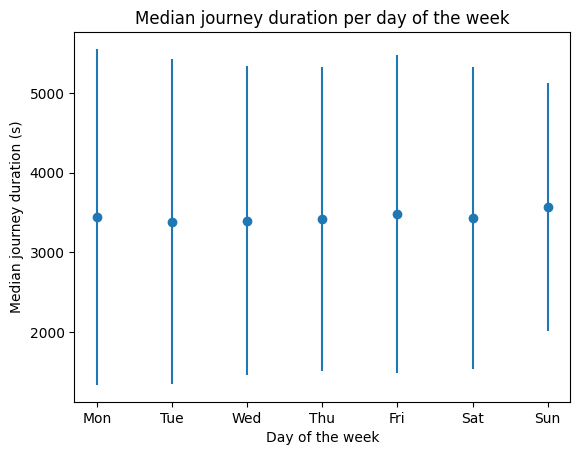

In [13]:

days = [departure.weekday() for departure in departures]
# get the unique days of the week
unique_days = set(days)

# calculate the average duration for each day of the week
average_durations = {}
std_devs = {}
medians = {}
for day in unique_days:
    # get the durations for the current day
    durations_for_day = [duration for duration, current_day in zip(durations, days) if current_day == day]
    
    # calculate the average duration
    average_duration = sum(durations_for_day) / len(durations_for_day)
    average_durations[day] = average_duration
    
    # calculate the standard deviation
    std_dev = (sum([(duration - average_duration) ** 2 for duration in durations_for_day]) / len(durations_for_day)) ** 0.5
    std_devs[day] = std_dev
    
    # calculate the median
    median = sorted(durations_for_day)[len(durations_for_day) // 2]
    medians[day] = median
    
# plot the average duration per day of the week with error bars
plt.errorbar(list(average_durations.keys()), list(average_durations.values()), yerr=list(std_devs.values()), fmt='o')
plt.xticks(list(average_durations.keys()), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of the week')
plt.ylabel('Average journey duration (s)')
plt.title('Average journey duration per day of the week')
plt.savefig('out/journeys/average_duration_per_day.png')
plt.show()

# plot the median duration per day of the week
plt.errorbar(list(medians.keys()), list(medians.values()), yerr=list(std_devs.values()), fmt='o')
plt.xticks(list(medians.keys()), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of the week')
plt.ylabel('Median journey duration (s)')
plt.title('Median journey duration per day of the week')
plt.savefig('out/journeys/median_duration_per_day.png')
plt.show()

Monday and Thursday seem to have the widest error bars while Saturday and Sunday seem to have the smallest.

### Average duration per time of day (morning, afternoon, evening, night)


In [14]:
# morning: 6:00 - 12:00
# afternoon: 12:00 - 18:00
# evening: 18:00 - 24:00
# night: 24:00 - 6:00
times_of_day = []
for departure in departures:
    if 6 <= departure.hour < 12:
        times_of_day.append('morning')
    elif 12 <= departure.hour < 18:
        times_of_day.append('afternoon')
    elif 18 <= departure.hour < 24:
        times_of_day.append('evening')
    else:
        times_of_day.append('night')
        
# get the unique times of day
unique_times_of_day = set(times_of_day)

# calculate the average duration for each time of day
average_durations = {}
std_devs = {}
medians = {}

for time_of_day in unique_times_of_day:
    # get the durations for the current time of day
    durations_for_time_of_day = [duration for duration, current_time_of_day in zip(durations, times_of_day) if current_time_of_day == time_of_day]
    
    # calculate the average duration
    average_duration = sum(durations_for_time_of_day) / len(durations_for_time_of_day)
    average_durations[time_of_day] = average_duration
    
    # calculate the standard deviation
    std_dev = (sum([(duration - average_duration) ** 2 for duration in durations_for_time_of_day]) / len(durations_for_time_of_day)) ** 0.5
    std_devs[time_of_day] = std_dev
    
    # calculate the median
    median = sorted(durations_for_time_of_day)[len(durations_for_time_of_day) // 2]
    medians[time_of_day] = median
    
print("Average Durations:", average_durations)
print("Median Durations:", medians)
print("Standard Deviations:", std_devs)

Average Durations: {'afternoon': 3454.804999406246, 'evening': 3440.700441074054, 'night': 4289.214074453083, 'morning': 3538.994270688381}
Median Durations: {'afternoon': 3390, 'evening': 3290, 'night': 3636, 'morning': 3469}
Standard Deviations: {'afternoon': 1074.455033653454, 'evening': 1678.894131970335, 'night': 3116.953457659952, 'morning': 1146.6568351088038}


In [15]:
# rearrange the keys so that they are in the correct order
average_durations = {key: average_durations[key] for key in ['morning', 'afternoon', 'evening', 'night']}
std_devs = {key: std_devs[key] for key in ['morning', 'afternoon', 'evening', 'night']}
medians = {key: medians[key] for key in ['morning', 'afternoon', 'evening', 'night']}
print(average_durations)
print(std_devs)

{'morning': 3538.994270688381, 'afternoon': 3454.804999406246, 'evening': 3440.700441074054, 'night': 4289.214074453083}
{'morning': 1146.6568351088038, 'afternoon': 1074.455033653454, 'evening': 1678.894131970335, 'night': 3116.953457659952}


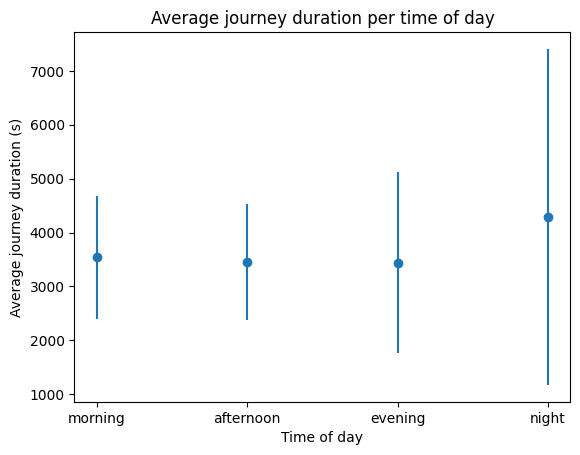

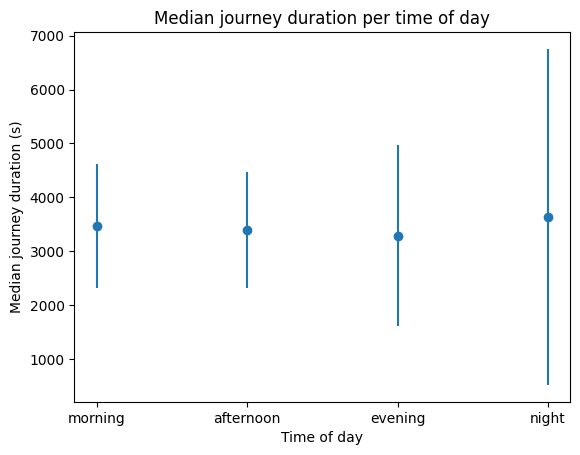

In [16]:
# plot the average duration per time of day in order (morning, afternoon, evening, night) with error bars
plt.errorbar(list(average_durations.keys()), list(average_durations.values()), yerr=list(std_devs.values()), fmt='o')
plt.xlabel('Time of day')
plt.title('Average journey duration per time of day')
plt.ylabel('Average journey duration (s)')
plt.savefig('out/journeys/average_duration_per_time_of_day.png')
plt.show()

# do the same with medians
plt.errorbar(list(medians.keys()), list(medians.values()), yerr=list(std_devs.values()), fmt='o')
plt.xlabel('Time of day')
plt.title('Median journey duration per time of day')
plt.ylabel('Median journey duration (s)')
plt.savefig('out/journeys/median_duration_per_time_of_day.png')
plt.show()

It seems like the shortest average and median travel times are in the evening and afternoon, while the longest average and median travel time is at night. Night also has the highest margin of error.